In [1]:
import argparse
import os
import time

import pygeos
import fiona # used to read layers of gdb file
import geopandas # used to load and analyze gdb files
from geopandas.tools import sjoin

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
# https://github.com/geopandas/geopandas/issues/1652

from joblib import Parallel, delayed
import multiprocessing

In short, Peromyscus maniculatus was split into 5 names circa 2019 making it a good MSW test case for tax splitting


summerize stats: 
    mammels: with, without coords
        Peromyscus with, without coords
            maniculatus with, without coords


and overview of interesting fields & their proportion of presence
lookup the dynamic properties for additional metrics (i.e., measurements)
probabilistic approach wrt morphometrics (if measurements are present)


GBIF source citation: 

GBIF.org (04 June 2021) GBIF Occurrence Download https://doi.org/10.15468/dl.phjg43 

Unless GBIF discovers citations of this download, the data file is eligible for deletion after June 4, 2022.

In [2]:
# operates on a sample of the dataset for process development / debugging
debugging = False

# a list of the newly split out names (Bradley et. al., 2019)
# commented out names are not accepted by MDD
name_author = {"Peromyscus arcticus" : "P. arcticus (Wagner 1845)",
                 "Peromyscus gambelii" : "P. gambelii (Baird 1857)",
                 "Peromyscus labecula" : "P. labecula (Elliot 1903)",
                 "Peromyscus maniculatus" : "P. maniculatus (Wagner 1845)",
                 "Peromyscus sonoriensis" : "P. sonoriensis (LeConte 1853)",
                 #"Peromyscus keeni" : "P. keeni (Rhoads 1894)",
                 #"Peromyscus melanotis" : "P. melanotis (J. A. Allen and Chapman 1897)",
                 #"Peromyscus polionotus" : "P. polionotus (Wagner 1843)",
                 #"Peromyscus sejugis" : "P. sejugis (Burt 1932)",
              }
new_names = list(name_author.keys())

In [3]:
# load in the range maps geopackage
gdf = geopandas.read_file("MDD_Rodentia_NAm_393species.gpkg")

# restrict the gdf to those ranges of interest
gdf = gdf[gdf['sciname'].isin(new_names)].copy()

# calculate area for everything
gdf.sindex # prepare spatial index

# check gdf projection
print(f"gdf is projected in: {gdf.crs}")

# examine availble gdf columns
display(gdf.columns)

/home/john/.local/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


gdf is projected in: epsg:4326


Index(['sciname', 'order', 'family', 'author', 'year', 'citation',
       'rec_source', 'geometry'],
      dtype='object')

In [4]:
# load in occurence data
occ = pd.read_csv("gbif_occurrences/0294669-200613084148143/occurrence.txt", sep='\t', header=0, low_memory=False)

# clean out incorrect coords.
occ = occ[occ['decimalLongitude'] < 0]

# might be able to skip the pandas df to gdf by directly loading to geopandas.
occ = geopandas.GeoDataFrame(occ, geometry=geopandas.points_from_xy(occ['decimalLongitude'], occ['decimalLatitude']))
occ = occ.set_crs("EPSG:4326")

In [28]:
print(occ.shape)

(184271, 252)


In [5]:
def concept_by_geo(chunk):
    rows = []
    for _, row_data in chunk.iterrows():
        point = row_data['geometry']   
        names = []
        for _, concept_data in gdf.iterrows():
            if point.within(concept_data['geometry']):
                # convert to authored_names
                authored_name = name_author.get(concept_data['sciname'], "")
                names.append(authored_name)
        if len(names) == 0:
            names = ["none"]
        names = " | ".join(names)
        row_data['suggested_names'] = names
        rows.append(row_data)
    rows = pd.concat(rows, axis=1)
    return rows

In [6]:
ncores = multiprocessing.cpu_count() - 4
def apply_parallel(df, func, n_jobs=ncores):
        # break df up into n chunks where n = ncore
        df_chunks =  np.array_split(df, n_jobs)
        rows = Parallel(n_jobs=n_jobs, prefer="processes", verbose=10)(delayed(func)(chunk) for chunk in df_chunks)
        result = pd.concat(rows, axis=1).T
        return result

print(f"started process at: {time.ctime()}")

if debugging:
    occ = apply_parallel(occ.sample(5000).copy(), concept_by_geo)
    occ.to_csv("peromyscus_concepts_sample.csv", index=False)
    
else:
    occ = apply_parallel(occ, concept_by_geo)
    occ.to_csv("peromyscus_concepts.csv", index=False)

print(f"finished process at: {time.ctime()}")

started process at: Thu Jun 10 14:54:14 2021


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed: 713.8min
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed: 1107.2min remaining: 3321.5min
[Parallel(n_jobs=12)]: Done   5 out of  12 | elapsed: 1172.5min remaining: 1641.5min
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed: 1234.6min remaining: 881.8min
[Parallel(n_jobs=12)]: Done   9 out of  12 | elapsed: 1353.3min remaining: 451.1min
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed: 1604.1min finished


finished process at: Fri Jun 11 17:39:28 2021


#### Summarise and validate the outcomes

_Note_: This section loads the "peromyscus_concepts.csv" csv previously generated to avoid re-running entire analysis during development.

In [7]:
#occ = pd.read_csv("peromyscus_concepts.csv", low_memory=False)
#print(occ.shape)

The goal of this section is to derive some general statistics concerning the preliminary study's output.

In [8]:
# generalize the outcomes
x = len(occ[occ['suggested_names'].isin(new_names)])
print(f"ratio of occurrences resulting in one suggestion: {(x / len(occ))}")

# multiple suggested names are delimited by "|"
x = len(occ[occ['suggested_names'].str.count("\|") == 1])
print(f"ratio of occurrences resulting in two suggestions {(x / len(occ))}")

x = len(occ[occ['suggested_names'].str.count("\|") > 1])
print(f"total number of occurrences resulting in >2 suggestions: {x}")

x = len(occ[occ['suggested_names']== "none"])
print(f"total number of occurrences resulting in no suggestion: {x}")
print(f"       ratio of occurrences resulting in no suggestion: {(x / len(occ))}")

ratio of occurrences resulting in one suggestion: 0.0
ratio of occurrences resulting in two suggestions 0.03659284423484976
total number of occurrences resulting in >2 suggestions: 0
total number of occurrences resulting in no suggestion: 11367
       ratio of occurrences resulting in no suggestion: 0.061686320690721816


The goal of this section is to quantify how frequently the names we suggest align with the suggestions presented in the Appendix of Bradley et. al., 2019. To do this:
- the appendix was extracted as a CSV from the PDF
- the catalog numbers (i.e., "Museum") in the appendix were aligned for the format used in GBIF
- the records Bradley et. al. was uncertain of (i.e., "Peromyscus sp.") were omitted from the appendix 
- the gbif derived occurrence records were then inner joined with the appendix records based on the aligned
- a 0/1 boolean column is derived which identifies if the names this process suggests (i.e., 'suggested_names') are equal to the names the appendix listed.

In [27]:
# note: re-ran this cell after initial analysis to test the author_name reverse dict conversion for mapping

# The appendix table from Bradley et. al. 2019 was parsed out into the csv file below.
# parsing was done using table selection tool from: Okular version 21.04.0

Bradley_appendix = pd.read_csv("Bradley_2019_appendix.csv")
# table selection has left a single hanging whitespace in each value, so clean it column by column.
# column names were manually cleaned from csv.
for col in Bradley_appendix.columns:
    Bradley_appendix[col] = Bradley_appendix[col].str.strip()

# Bradley's Museum column should closely map to occ's "catalogNumber"
# examine samples of each to validate that.

print("Museum column from appenxis of Bradley et. al. 2019")
display(Bradley_appendix['Museum'].sample(5)) # examine "Museum" column

print("catalogNumber column from GBIF occurrence records (aka: 'occ')")
display(occ['catalogNumber'].sample(5)) # examine "catalogNumbers"

# 'Museum' column frequently includes a space between a catalog number and a museum abbreviation
# split each value in 'Museum' on white space, keep the first element as a museum abbreviation
abbreviations = Bradley_appendix['Museum'].str.split().str[0].unique()
display(abbreviations) # examine the abbreviations, and derive a simplified list

# simplified the list based on the displayed abbreviations
abbreviations = ['MSB', 'TTU', 'MVZ', 'WM', 'HGPeke', 'UAM',
                 'UWBM', 'OSM', 'CM', 'SP', 'NK', 'CRD', 'JFS',
                 'CIB', 'EAR', 'BYU', 'TK', 'Jonesboro']

Museum column from appenxis of Bradley et. al. 2019


146     UAM 23425
404    MSB 194085
640     MSB145572
457     MSB 74669
196     UAM 31725
Name: Museum, dtype: object

catalogNumber column from GBIF occurrence records (aka: 'occ')


155503              26531
145093    MSB:Mamm:122601
33811               42749
4829               186526
115454      UMNH:Mamm:534
Name: catalogNumber, dtype: object

array(['MSB', 'TTU', 'MVZ', 'WM', 'HGPeke', 'UAM', 'UWBM', 'UAM23437',
       'UAM23438', 'UAM31104', 'UAM48129', 'UAM49643', 'UAM23667',
       'UAM43024', 'UAM23775', 'UAM20620', 'UAM20662', 'UAM20664',
       'UAM23657', 'UAM23658', 'UAM23730', 'UAM23771', 'UAM23773',
       'UAM30343', 'UAM30590', 'UAM30819', 'UAM30873', 'UAM31105',
       'UAM31106', 'UAM35318', 'UAM42578', 'UAM42579', 'UAM43469',
       'UAM44887', 'UAM50436', 'UAM52310', 'UAM60272', 'UAM74125',
       'UAM74128', 'UAM74131', 'UAM76238', 'UAM76353', 'UAM76821',
       'UAM76822', 'UAM23106', 'OSM', 'CM', 'CM109317', 'SP', 'CM109548',
       'NK', 'CRD', 'JFS', 'CLP1113', 'CLP1114', 'CLP1116', 'CLP1117',
       'CLP1118', 'CLP1119', 'CLP1120', 'CLP1121', 'CLP1122', 'CLP1123',
       'CLP1124', 'CLP1125', 'CLP1126', 'CIB', 'MSB156182', 'MSB156150',
       'MSB156183', 'MSB83399', 'MSB83409', 'MSB83419', 'MSB83417',
       'MSB156370', 'MSB156589', 'MSB56704', 'MSB56705', 'MSB56706',
       'MSB156364', 'MSB156365',

In [10]:
# iterate over each abbreviation to find which are present among occ's catalogNumber

present_abbreviations = [] # container to hold the results
for abb in abbreviations:
    qty_present = len(occ[occ['catalogNumber'].str.contains(abb)]['catalogNumber'])
    if qty_present > 0:
        present_abbreviations.append(abb)

# finally examine the mapping from Bradley's appendix to GBIF's (occ) catalogNumber
for abb in present_abbreviations:
    sample = Bradley_appendix[Bradley_appendix['Museum'].str.contains(abb)]['Museum'].sample(1).tolist()[0]
    print(f"Bradley's 'Museum' represents {abb} as: {sample}")
    
    sample = occ[occ['catalogNumber'].str.contains(abb)]['catalogNumber'].sample(1).tolist()[0]
    print(f"occ 'catalogNumber' represents {abb} as: {sample}")
    print()

# among those results, it looks like "UCM:Mamm:#####" is a false posative for "CM ######"
# remove CM from the list of present_abbreviations
present_abbreviations.remove("CM")

Bradley's 'Museum' represents MSB as: MSB 74886
occ 'catalogNumber' represents MSB as: MSB:Mamm:153364

Bradley's 'Museum' represents MVZ as: MVZ 207863
occ 'catalogNumber' represents MVZ as: MVZ:Mamm:125830

Bradley's 'Museum' represents UAM as: UAM 50751
occ 'catalogNumber' represents UAM as: UAM:Mamm:53925

Bradley's 'Museum' represents UWBM as: UWBM 73836
occ 'catalogNumber' represents UWBM as: UWBM:Mamm:66864

Bradley's 'Museum' represents CM as: CM 106500
occ 'catalogNumber' represents CM as: UCM:Mamm:21039



In [22]:
# note: re-ran this cell after initial analysis to include the author_name reverse dict conversion for mapping
def mus_to_cat(museum_acc_number):
    """
    a function used to convert museum accession numbers extracted from the appenxid of Bradly et. al. 2019
    into the format used for GBIF's (occ) catalogNumber
    """
    return ":Mamm:".join(museum_acc_number.split())

# filter records in which Bradley_appendix is uncertain of a name
Bradley_appendix = Bradley_appendix[Bradley_appendix['sciName'] != 'Peromyscus sp.']

# filter the Bradley_appendix based on presence of a present_abbreviations in 'Museum'
abb_pattern = '|'.join(r"\b{}\b".format(x) for x in present_abbreviations)
Bradley_appendix = Bradley_appendix[Bradley_appendix['Museum'].str.contains(abb_pattern)]
# transform "Museum" col into GBIF-ish format using mus_to_cat
Bradley_appendix['catalogNumber'] = Bradley_appendix['Museum'].apply(mus_to_cat)

trimmed_Bradley_appendix = Bradley_appendix[['catalogNumber', 'Museum', 'GenBank', 'sciName']]
trimmed_occ = occ[['gbifID', 'catalogNumber', 'scientificName', 'suggested_names']]

mapped_records = trimmed_Bradley_appendix.merge(trimmed_occ,
                                                on='catalogNumber', 
                                                suffixes=('_Bradley', '_GBIF'))

mapped_records.rename({'sciName':'Bradley_name',
                       'Museum':'Bradley_museum',
                      'scientificName':'GBIF_name'}, axis=1, inplace=True)

# reverse the sci_name conversion for mapping names to Bradley
author_name = {v:k for k, v in name_author.items()}
mapped_records['suggested_names'] = mapped_records['suggested_names'].apply(lambda x: author_name.get(x,x))

# generate a "name_agreement" column for simplicity
mapped_records['name_agreement'] = mapped_records['Bradley_name'] == mapped_records['suggested_names']
mapped_records['name_agreement'] = mapped_records['name_agreement'].astype(int)

# reorder columns to preference
mapped_records = mapped_records[['catalogNumber', 'Bradley_museum', 'GenBank', 'gbifID',
                                 'GBIF_name', 'Bradley_name', 'suggested_names', 'name_agreement']]


# examine the result & shape
print(f"mapped_records shape: {mapped_records.shape}")
display(mapped_records.sample(3))

mapped_records shape: (205, 8)


catalogNumber Bradley_museum   GenBank      gbifID  \
40   UAM:Mamm:71580      UAM 71580  KF949348   897082727   
189  MSB:Mamm:72135      MSB 72135  DQ385688  1145362964   
62   MSB:Mamm:74561      MSB 74561  DQ385757  1145365641   

                                 GBIF_name            Bradley_name  \
40   Peromyscus maniculatus (Wagner, 1845)        Peromyscus keeni   
189  Peromyscus maniculatus (Wagner, 1845)  Peromyscus sonoriensis   
62   Peromyscus maniculatus (Wagner, 1845)  Peromyscus maniculatus   

            suggested_names  name_agreement  
40                     none               0  
189  Peromyscus sonoriensis               1  
62                     none               0

In [23]:
mapped_records.groupby("suggested_names").describe()['name_agreement']

count     mean       std  min  25%  50%  75%  max
suggested_names                                                          
Peromyscus arcticus       2.0  0.00000  0.000000  0.0  0.0  0.0  0.0  0.0
Peromyscus gambelii      11.0  1.00000  0.000000  1.0  1.0  1.0  1.0  1.0
Peromyscus maniculatus    8.0  0.37500  0.517549  0.0  0.0  0.0  1.0  1.0
Peromyscus sonoriensis  119.0  0.92437  0.265524  0.0  1.0  1.0  1.0  1.0
none                     65.0  0.00000  0.000000  0.0  0.0  0.0  0.0  0.0

In [24]:
mapped_records.to_csv('geo_align_validation.csv')

#### Simplify the outputs and plot the points

In [14]:
def dynamicPropertiesFormatter(prop):
    """
    Function which attempts to parse a dictionary and unify the keys from the dynamicProperties data.
    """

    try: # first try to convert it directly to a dict
        parsed_properties = eval(prop)
    except: # if it is not a dict already attempt to construct one based on common delimiters
        
        assert type(prop) is str # ensure we are working with a string
        parsed_properties = {}  # container for the parsed results

        # first split distinct key, value pairs on ";"
        dproperties = prop.split(";")
    
        # for each key, value pair within the dproperties...
        for dproperty in dproperties:
            try: # try to split key from value on first equals sign
                key, val = dproperty.split("=", 1) # maxsplit=1
            except ValueError:
                # if that fails, split key from value on first equals sign
                try:
                    key, val = dproperty.split(":", 1)
                except ValueError:
                    # if both fail, just add the entire string as a value under the key: "verbatimDynamicProperty"
                    key = 'verbatimDynamicProperty'
                    val = dproperty.lower().strip()

            parsed_properties[key] = val
    # iterate over each key, value pair for alignment cleaning
    formatted_results = {} # container for the formatted results
    for key, val in parsed_properties.items():
        # force keys to lower case and strip excess white space
        key = key.lower().strip()
        val = val.lower().strip()
        
        # process is producing a non-trivial amount of keys formatted similar to:
        # '{""totalLengthInmm""', or '{ "massingrams"'
        if key[0] == "{":
            key = key.lstrip('{""').rstrip('""')
        key = key.lstrip(' "')
        formatted_results[key] = val

    return formatted_results

def isolate_factors(row_data):
    # trim down data
    row_data = row_data[['gbifID','decimalLatitude','decimalLongitude',
                        'coordinateUncertaintyInMeters', 'scientificName',
                        'acceptedScientificName', 'verbatimScientificName',
                        'suggested_names', 'sex', 'dynamicProperties', 'eventDate', 
                        'month', 'references', 'identifiedBy', 'elevation']]

    # attempt to parse the dynamicProperties
    dynamic_props = dynamicPropertiesFormatter(row_data['dynamicProperties'])
    try:
        hind = float(dynamic_props.get("hind foot with claw", "0").replace("mm", "").strip())
        weight = float(dynamic_props.get("weight", "0").replace("g", "").strip())
        ear = float(dynamic_props.get("ear from notch", "0").replace("mm", "").strip())
        total = float(dynamic_props.get("total length", "0").replace("mm", "").strip())
        tail = float(dynamic_props.get("tail length", "0").replace("mm", "").strip())
    except ValueError:
        hind = 0
        weight = 0
        ear = 0
        total = 0
        tail = 0

    row_data["ear from notch"] = ear
    row_data["hind foot with claw"] = hind
    row_data["weight"] = weight
    row_data["total length"] = total
    row_data["tail length"] = tail

    if 0 in [hind,weight]:
        row_data["hind per weight (mm/g)"] = np.nan
    else:
        #derive a density metric
        row_data["hind per weight (mm/g)"] = round(hind / weight, 3)

    return row_data

occ['dynamicProperties'].fillna("", inplace = True)
trimmed_occ = occ.apply(isolate_factors, axis=1)
if debugging:
    trimmed_occ.to_csv("trimmed_occ_sample.csv", index=False)
else:
    trimmed_occ.to_csv("trimmed_occ.csv", index=False)

#### Plot the occurrences

In [15]:
plt.rcParams['figure.figsize'] = [8, 10]
plt.rcParams['figure.dpi'] = 400

In [16]:
# used during development to avoid re-running the parsing function
#occ = geopandas.GeoDataFrame(occ, geometry=geopandas.points_from_xy(occ['decimalLongitude'], occ['decimalLatitude']))
#occ = occ.set_crs("EPSG:4326")

In [25]:
# note re-ran this cell to modify the fig.
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# restrict to North America
world = world[world.continent == 'North America']

# useful for seeing individual ranges
#world = gdf.copy()
#world = world[world['sciname'] == 'Peromyscus maniculatus']

# set an appropriate projection
project = "EPSG:2163"
world = world.to_crs(project)

gdb_occ = geopandas.GeoDataFrame(occ[['geometry', 'suggested_names', 'acceptedScientificName']], geometry='geometry')
gdb_occ = gdb_occ.set_crs("EPSG:4326") # I believe the default from gbif
# reproject points to "project" for figure production
gdb_occ = gdb_occ.to_crs(project)

<Figure size 3200x4000 with 0 Axes>

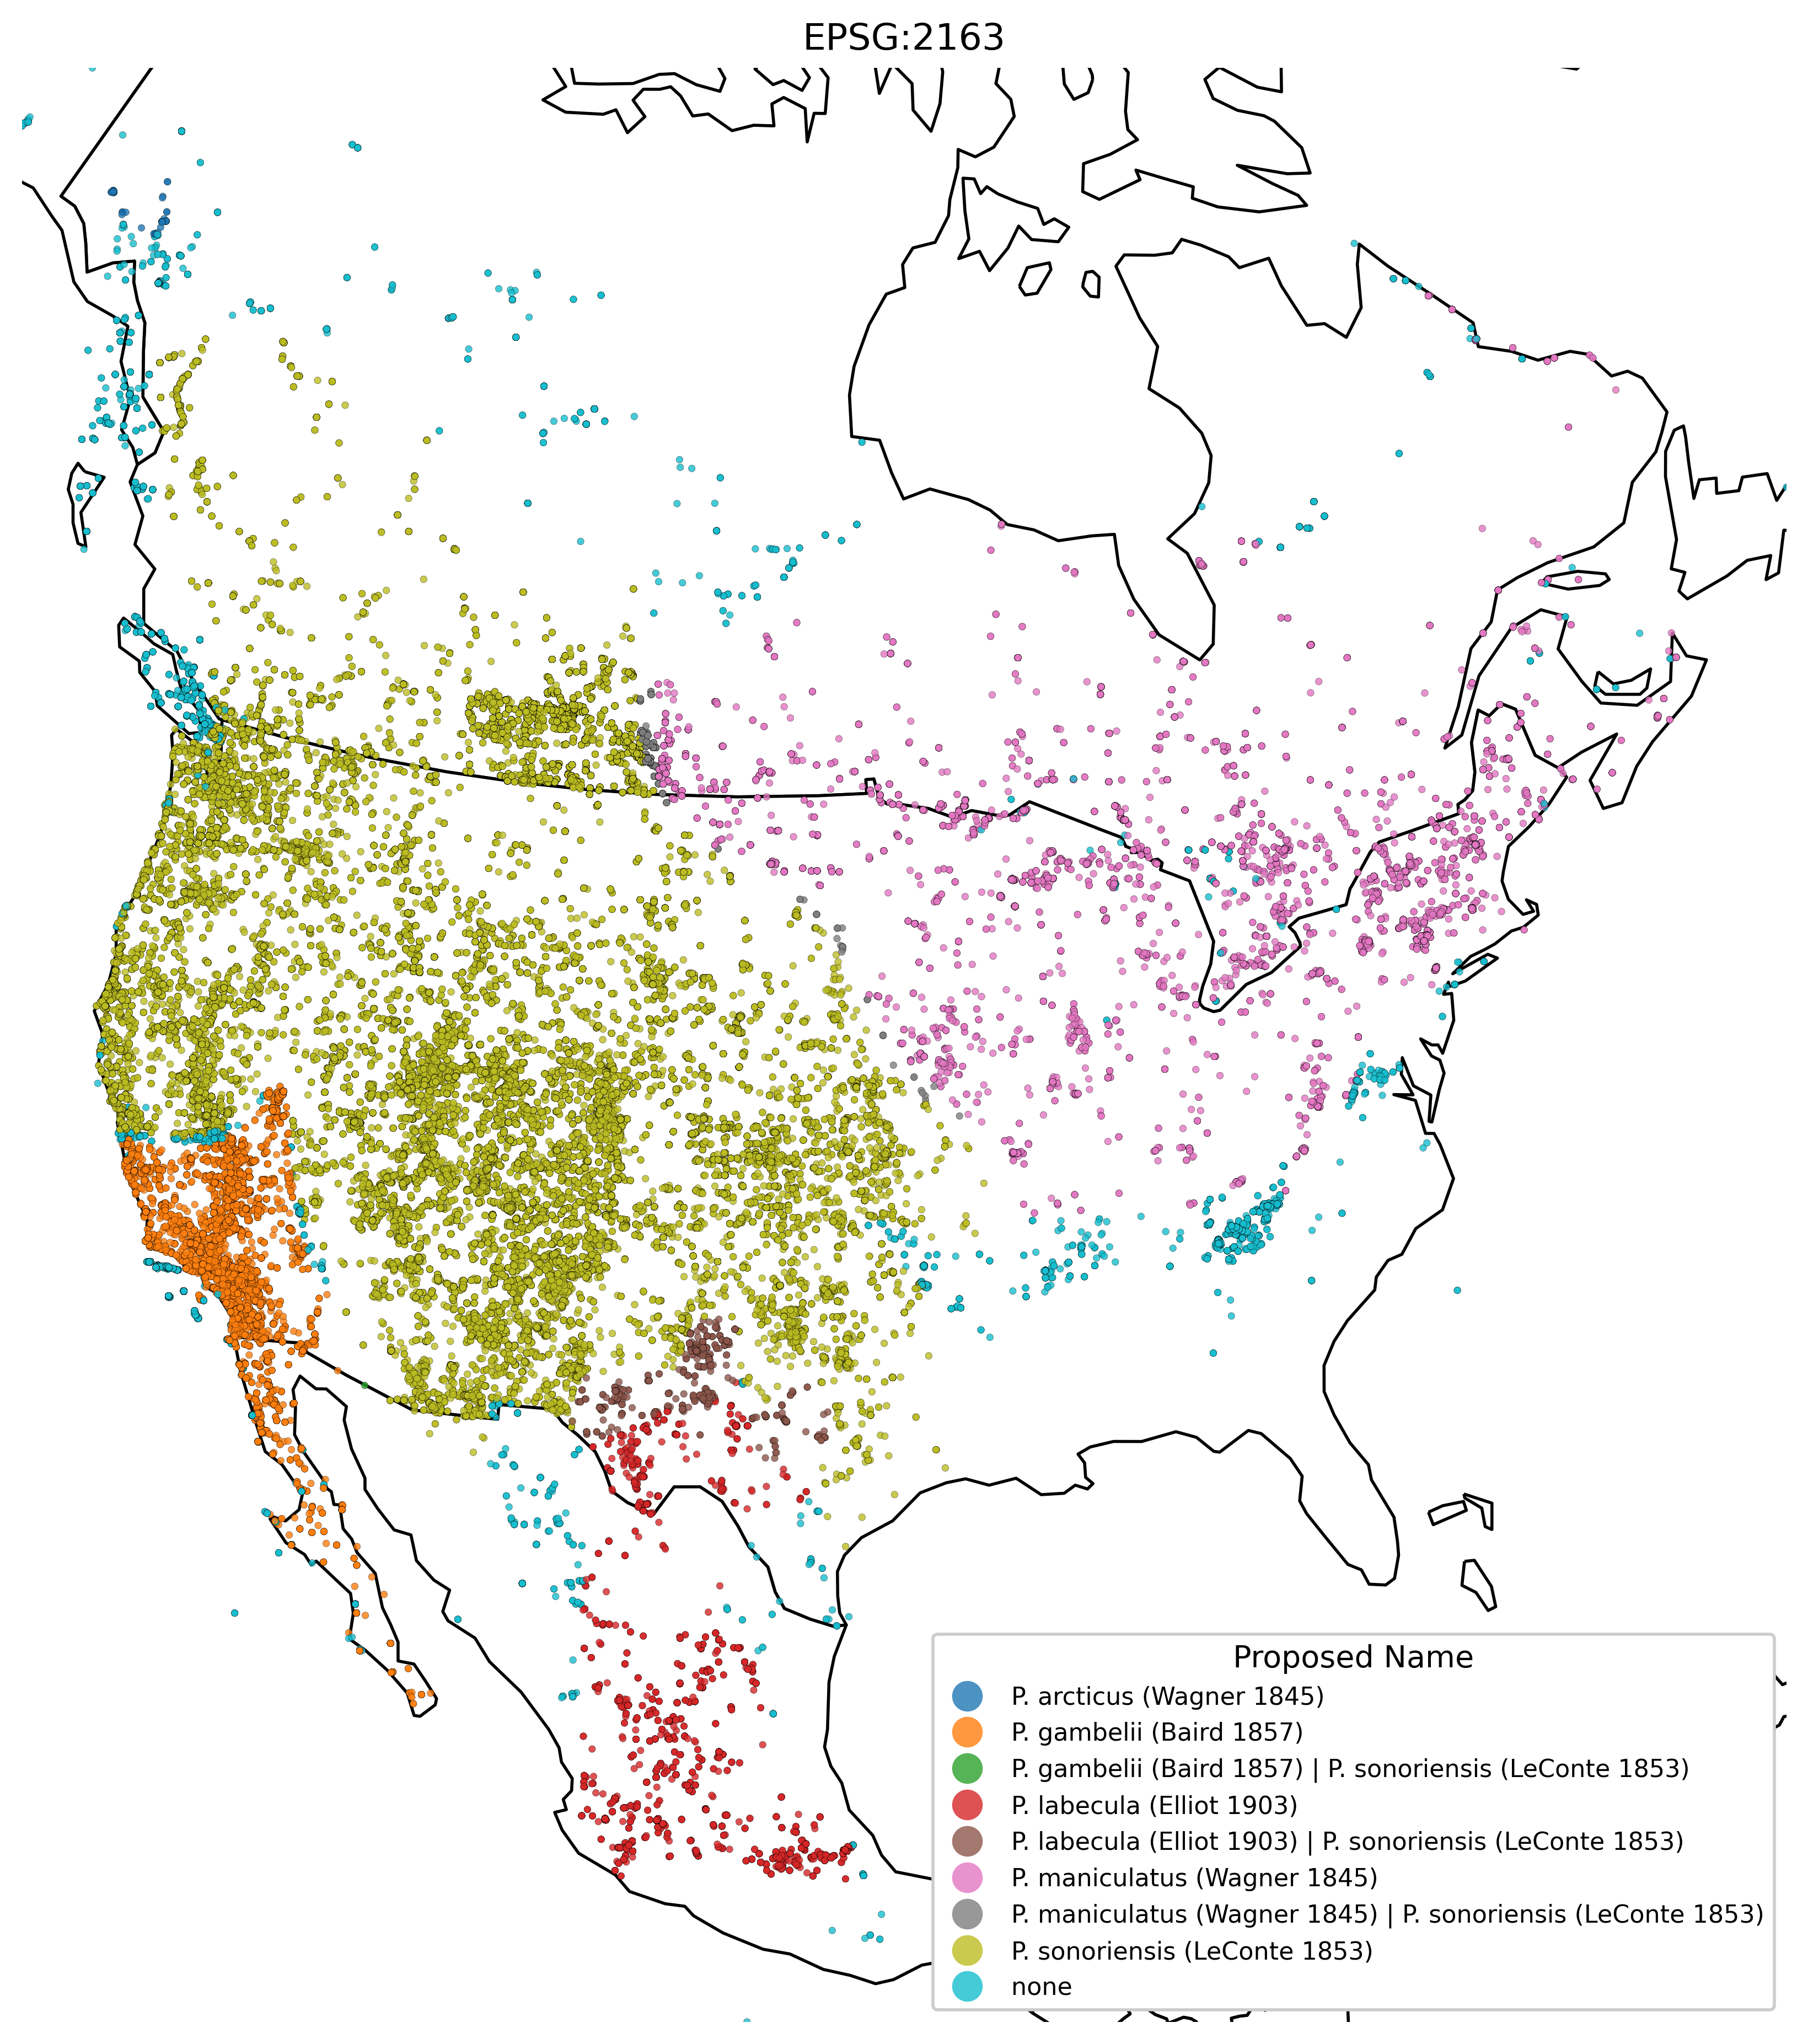

In [26]:
# note re-ran this cell to modify the fig.
target_feature = 'suggested_names'
try:
    plt.clear() 
except:
    pass

fig = plt.figure()
ax = world.plot(color='white', edgecolor='black')

# establish the region of interest
padding = 3
minx, miny, maxx, maxy = gdb_occ.total_bounds
ax.set_xlim(minx-padding, maxx+padding)
ax.set_ylim(miny-padding, maxy+padding)
ax.axis("off")
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.title(project)
gdb_occ.plot(ax=ax,
            column=target_feature,
            categorical=True,
            #cmap='viridis',
            cmap='tab10',
            label=target_feature,
            marker="o",
            markersize=5,
            alpha=.8,
            edgecolors='k',
            linewidth=0.08,
            legend=True,
            legend_kwds={'loc': 'lower right',
                         'fontsize' : 8,
                         'title': 'Proposed Name',
                         'framealpha' : 1.0,})
if debugging:
    plt.savefig("Peromyscus_sample.jpg", pad_inches=0)
else:
    plt.savefig("Peromyscus_all.jpg", pad_inches=0)